The recommended dataset for this exercise is available here:
http://opihi.cs.uvic.ca/sound/genres.tar.gz

In [0]:
import sys
import re 
import numpy as np 
import pandas as pd
import music21
from glob import glob
import IPython
from tqdm import tqdm
import pickle
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from music21 import converter, instrument, note, chord, stream

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K


In [0]:
song_specs=[]
genres = []
for genre in os.listdir('...'):  # Path to genres folder
  song_folder = '...'  # Path to songs folder
  for song in os.listdir(song_folder):
    if song.endswith('.au'):
      signal, sr = librosa.load(os.path.join(song_folder, song), sr=16000)
      melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
      song_specs.append(melspec)
      genres.append(genre)
      print(song)
  print('Done with:', genre)

In [0]:
song_specs[5].shape

(938, 128)

In [0]:
song_specs[5][0].shape

(128,)

In [0]:
song_specs2 = []
for i in range(len(song_specs)):
  tmp = song_specs[i]
  song_specs2.append(tmp[:900][:])

In [0]:
song_specs2 = np.array(song_specs2)
song_specs2.shape

(1000, 900, 128)

Text(0.5, 1.0, 'Rock audio spectrogram')

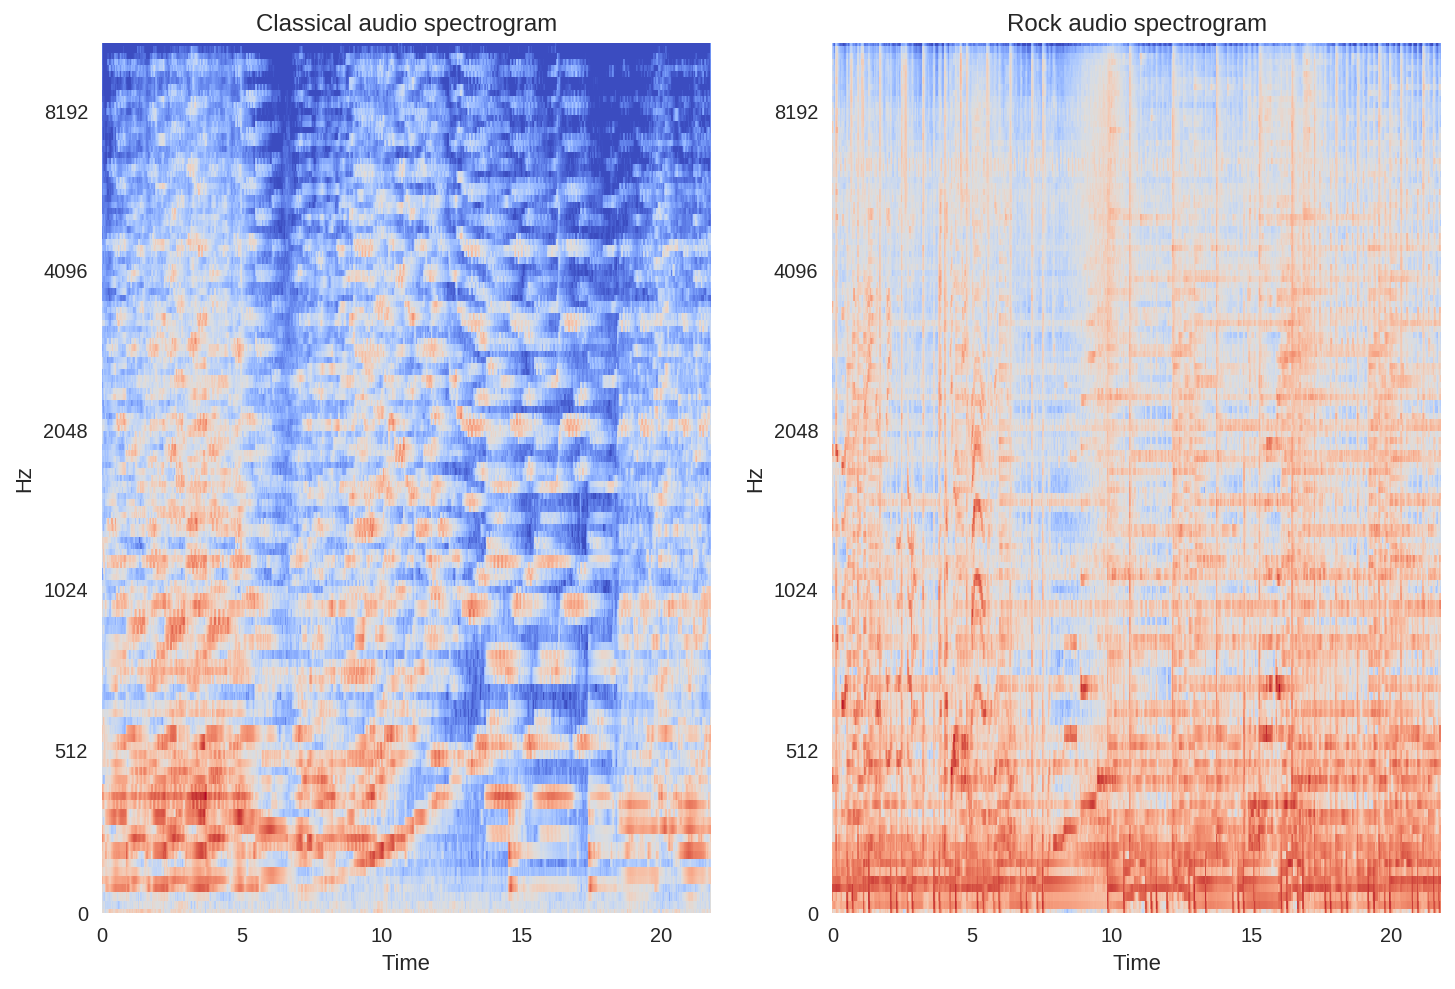

In [0]:
plt.subplot(121)
librosa.display.specshow(librosa.power_to_db(song_specs[302].T),
                          y_axis='mel',
                          x_axis='time',)
plt.title('Classical audio spectrogram')
plt.subplot(122)
librosa.display.specshow(librosa.power_to_db(song_specs[402].T),
                          y_axis='mel',
                          x_axis='time',)
plt.title('Rock audio spectrogram')

Text(0.5, 1.0, 'Classical audio spectrogram')

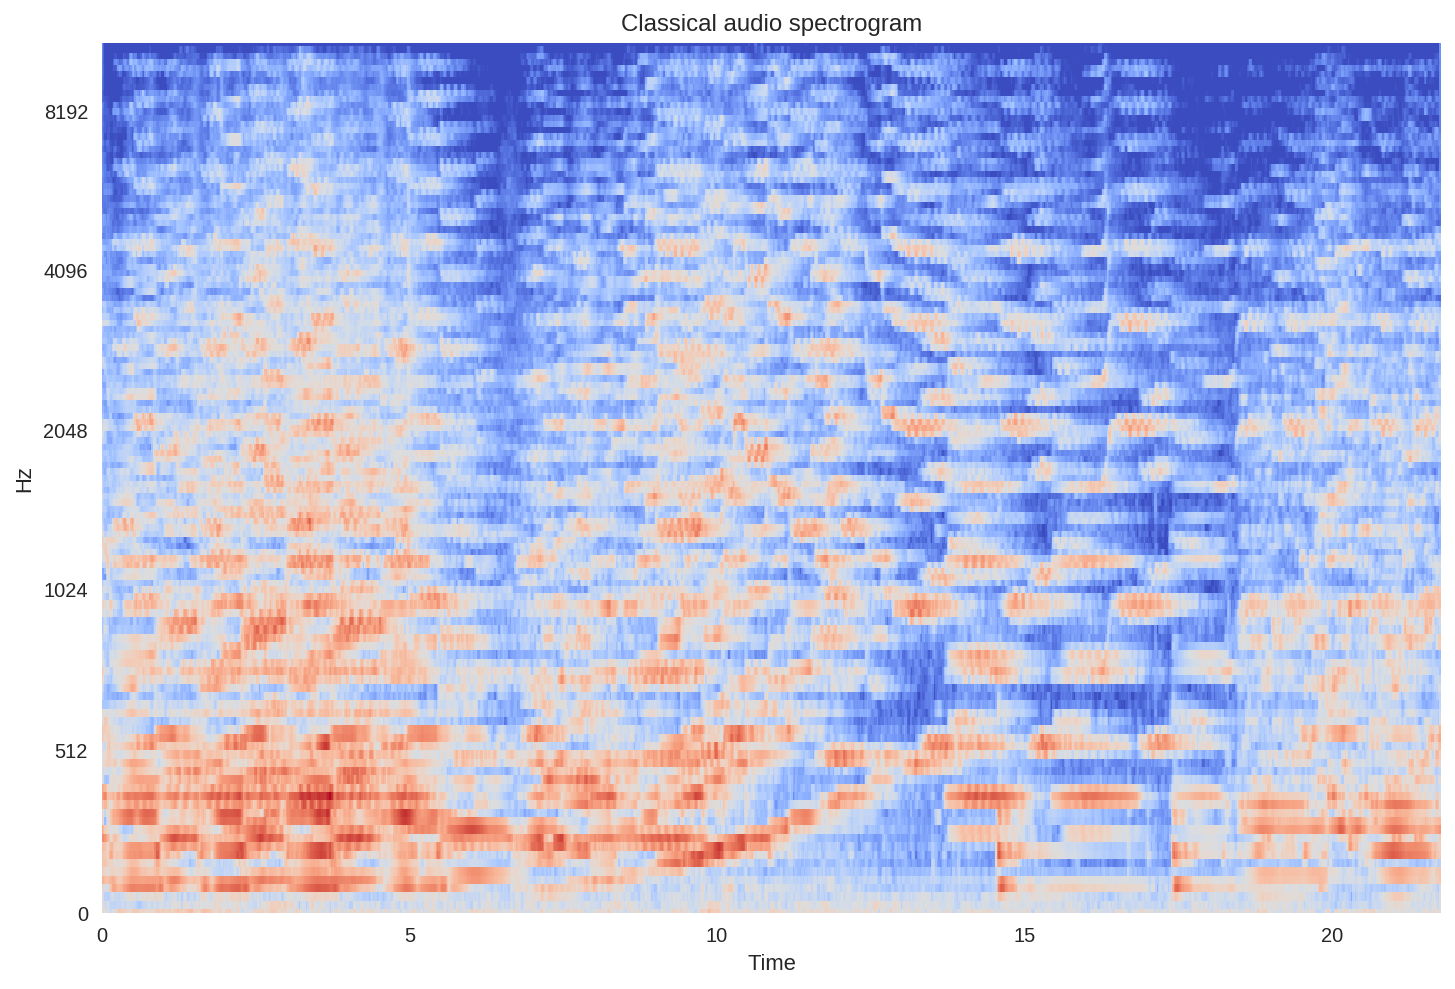

In [0]:
librosa.display.specshow(librosa.power_to_db(song_specs[302].T),
                          y_axis='mel',
                          x_axis='time',)
plt.title('Classical audio spectrogram')

In [0]:
song_specs = np.array(song_specs)

In [0]:
genre_one_hot = pd.get_dummies(genres)

In [0]:
song_specs.shape

(1000,)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(song_specs2, np.array(genre_one_hot),test_size=0.1,random_state = 42)

In [0]:
input_shape = (900, 128)
inputs = Input(input_shape)
x = inputs
levels = 64

for level in range(7):
    x = Conv1D(levels, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    levels *= 2

x = GlobalMaxPooling1D()(x)

for fc in range(2):
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

labels = Dense(10, activation='softmax')(x)

In [0]:
model = Model(inputs=[inputs], outputs=[labels])
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 900, 128)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 898, 64)           24640     
_________________________________________________________________
batch_normalization_15 (Batc (None, 898, 64)           256       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 449, 64)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 447, 128)          24704     
_________________________________________________________________
batch_normalization_16 (Batc (None, 447, 128)          512       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 223, 128)          0         
__________

In [0]:
x_train.shape

(900, 900, 128)

In [0]:
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 15s 16ms/step - loss: 4.0980 - acc: 0.1800 - val_loss: 2.0659 - val_acc: 0.3100
Epoch 2/100
900/900 [==============================] - 4s 4ms/step - loss: 2.7302 - acc: 0.2711 - val_loss: 2.1467 - val_acc: 0.3000
Epoch 3/100
900/900 [==============================] - 4s 4ms/step - loss: 2.3180 - acc: 0.3211 - val_loss: 2.1386 - val_acc: 0.3500
Epoch 4/100
900/900 [==============================] - 4s 4ms/step - loss: 2.2587 - acc: 0.3267 - val_loss: 1.8490 - val_acc: 0.3200
Epoch 5/100
900/900 [==============================] - 4s 4ms/step - loss: 2.3186 - acc: 0.2911 - val_loss: 1.6381 - val_acc: 0.4500
Epoch 6/100
900/900 [==============================] - 4s 4ms/step - loss: 2.0518 - acc: 0.3567 - val_loss: 1.6923 - val_acc: 0.4300
Epoch 7/100
900/900 [=======

In [0]:
from keras.models import Model
layer_name = 'dense_8'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(song_specs2)

In [0]:
!pip install ggplot

    100% |████████████████████████████████| 2.2MB 12.4MB/s 


In [0]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_img_label = tsne_model.fit_transform(intermediate_output)
tsne_df = pd.DataFrame(tsne_img_label, columns=['x', 'y'])
tsne_df['image_label'] = genres

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.597620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.213737
[t-SNE] KL divergence after 1000 iterations: 0.588185


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

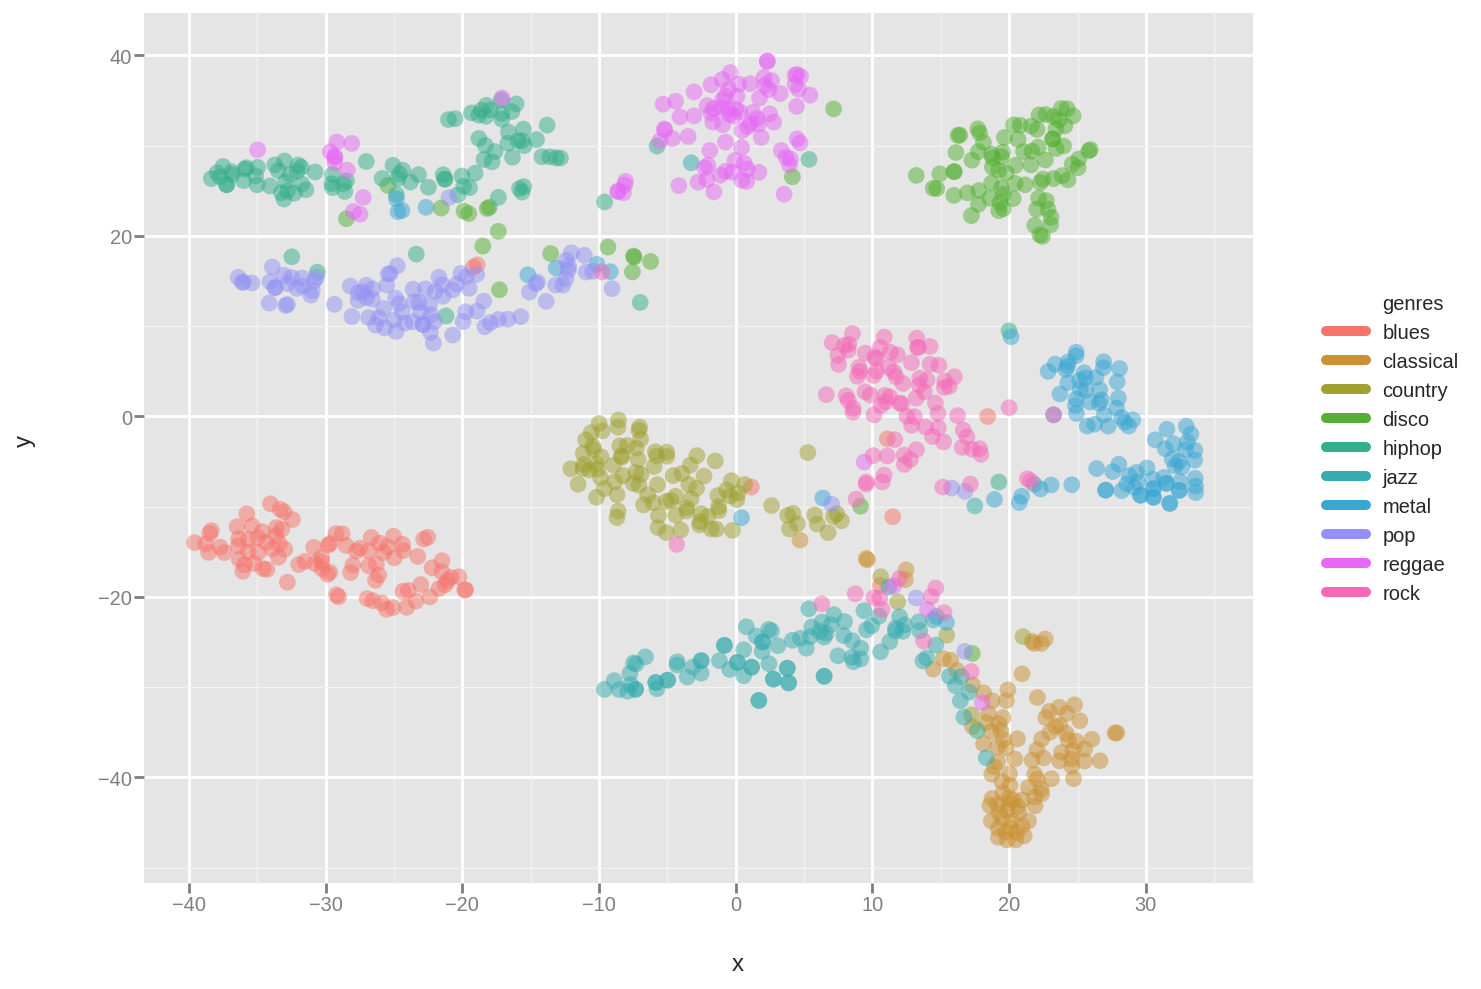

<ggplot: (8792557244378)>

In [0]:
from ggplot import *
chart = ggplot(tsne_df, aes(x='x', y='y', color='genres'))+ geom_point(size=70,alpha=0.5)
plt.axis('off')
chart